# CICERO SCM notebook example - interactive input

Import some stuff

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Import the model

In [2]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [3]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

In [4]:
def to_df(cscm):
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out

set up input directories

In [5]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [6]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_SO2,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [7]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [8]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [9]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,2.440048,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,2.408379,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,2.397116,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,2.410693,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,2.462065,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [10]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1751,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

DEBUG: Flat params in pamset_emiconc: []


and run it!

## Parameter Organization

The model parameters are organized into different categories:

- **pamset_udm**: Physical oceanographic parameters (upwelling-diffusion model)
- **pamset_emiconc**: Emissions and concentrations parameters, including forcing coefficients
- **pamset_carbon**: Carbon cycle specific parameters

### Carbon Cycle Parameters

Carbon cycle parameters should be passed in `pamset_carbon`. This includes:

- Physical parameters: `beta_f`, `mixed_carbon`, `npp0`, `ml_w_sigmoid`, `ml_fracmax`, `ml_t_half`, etc.
- Function parameters: Can use either dictionary or flat format

### Using Flat Carbon Cycle Parameters

The carbon cycle function parameters can now be specified using "flat" parameter names instead of requiring dictionary structures. For example, instead of:

```python
rb_function = {"coeffs": [0.5, 0.25, 0.25], "timescales": [2.5, 10.0, 60.0]}
```

You can now use:

```python
'rb_coef0': 0.5, 'rb_coef1': 0.25, 'rb_coef2': 0.25,
'rb_tim0': 2.5, 'rb_tim1': 10.0, 'rb_tim2': 60.0
```

In [65]:
# NBVAL_IGNORE_OUTPUT
cscm_dir._run({
            "results_as_dict":True,
            "carbon_cycle_outputs":True
        },
    pamset_udm={"threstemp": 7.0, #scales vertical velocity as a function of mixed layer temperature
                    "rlamdo":16.0,#air-sea heat exchange coefficient (wm^-2K^-1)
                    "akapa":0.634, #vertical heat diffusivity
                    "cpi":0.4, #temperature change ratio: polar to nonpolar region
                    "W":4, #vertical velocity (m/yr)
                    "beto":3.5, #ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
                    "lambda":0.54,
                    "mixed":60.0,  #mixed layer depth
                    "foan":0.61, #fraction of northern hemisphere covered by ocean
                    "foas":0.81, #fraction of northern hemisphere covered by ocean
                    "ebbeta":0.0,#atmospheric interhemispheric heat exchange 
                    "fnso":0.7531, #ocean area ratio, northern to southern hemisphere
                    "lm":40, #number of vertical layers
                    "ldtime":12,
                   },
    pamset_emiconc={"qbmb": 0.0,
                    "qo3": 0.5,
                    "qdirso2": -0.00308,
                    "qindso2": -0.97 / 57.052577209999995,
                    "qbc": 0.0279,
                    "qoc": -0.00433,
                    "qh2o_ch4": 0.091915,
                    "ref_yr": 2010
                    },
    pamset_carbon={
                    "beta_f": 0.,
                    "mixed_carbon": 75.0,
                    "qnmvoc": 0.0,
                    "qnh3": 0.0,
                    "qnox": 0.0,
                    "npp0": 60.0,
                    "npp_t_half": 0.5,
                    "npp_w_sigmoid": 4,
                    "npp_t_threshold": 6,
                    "npp_w_threshold": 4,
                    "ml_w_sigmoid": 3.0,
                    "ml_fracmax": 0.5,
                    "ml_t_half": 0.5,
                    'rb_coef0': 0.5,
                    'rb_coef1': 0.25,
                    'rb_coef2': 0.25,
                    'rb_tim0': 2.5,
                    'rb_tim1': 10.0,
                    'rb_tim2': 60.0,
                    'rs_coef0': 0.1,
                    'rs_coef1': 0.6,
                    'rs_coef2': 0.15,
                    'rs_coef3': 0.15,
                    'rs_tim0': .8,
                    'rs_tim1': 7,
                    'rs_tim2': 80,
                    'beta_f': 1.0
                }
            )   



[0.1  0.6  0.15 0.15] [ 0.8  7.  80. ]


Convert the output to a dataframe for easy handling

In [66]:

df_temp = to_df(cscm_dir)

# Plot output

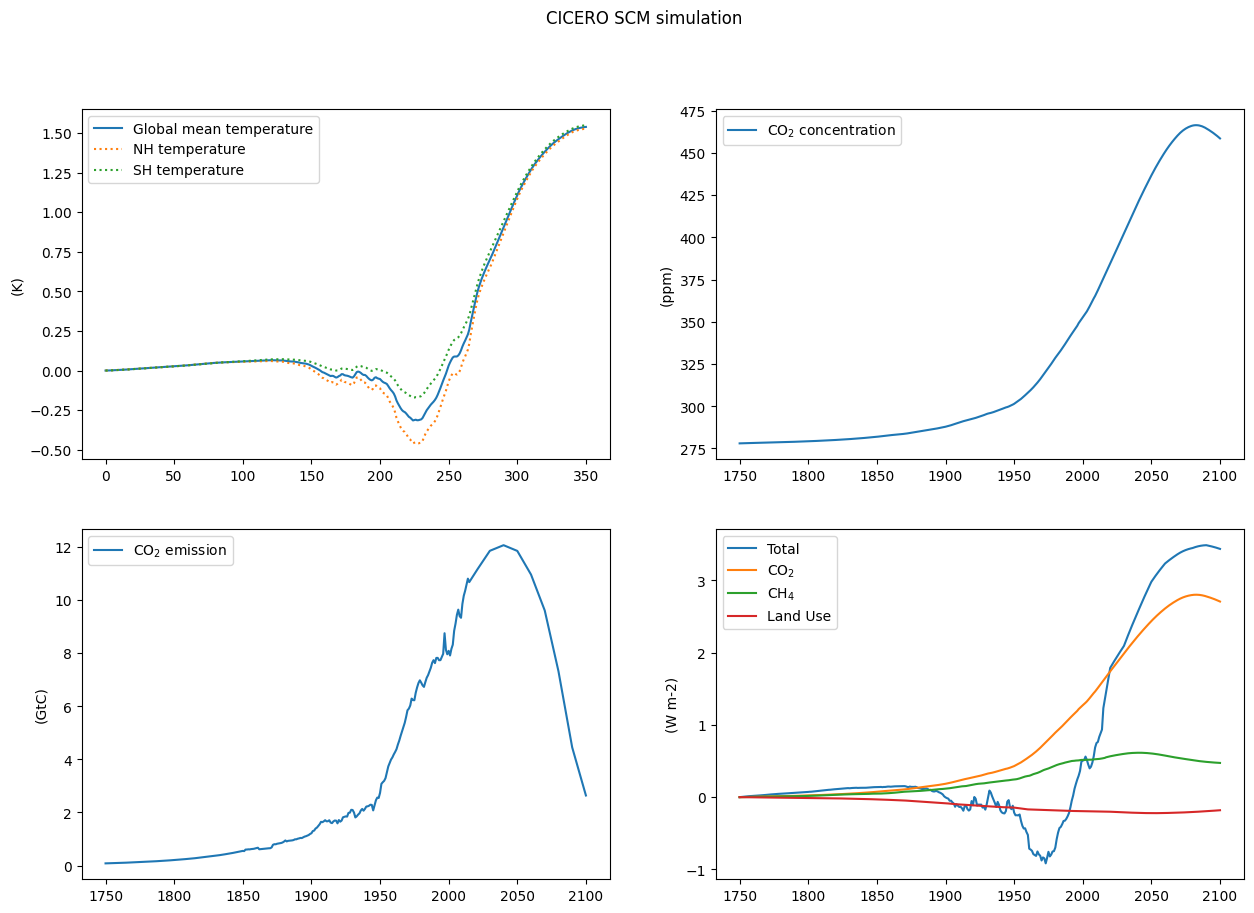

In [67]:
# NBVAL_IGNORE_OUTPUT
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
axs=axs.flatten()
fig.suptitle('CICERO SCM simulation')

df_temp['dT_glob'].plot(ylabel='(K)',ax=axs[0])
df_temp['dT_NH'].plot(ylabel='(K)',ax=axs[0],linestyle=':')
df_temp['dT_SH'].plot(ylabel='(K)',ax=axs[0],linestyle=':')
axs[0].legend(['Global mean temperature','NH temperature','SH temperature'])

df_temp['concentrations']['CO2'].plot(ylabel='(ppm)',ax=axs[1])
axs[1].legend([r'CO$_2$ concentration'])

df_temp['emissions']['CO2'].plot(ylabel='(GtC)',ax=axs[2])
axs[2].legend([r'CO$_2$ emission'])

df_temp["forcing"]["Total_forcing"].plot(ylabel='(W m-2)',ax=axs[3])
df_temp["forcing"]["CO2"].plot(ylabel='(W m-2)',ax=axs[3])
df_temp["forcing"]["CH4"].plot(ylabel='(W m-2)',ax=axs[3])
df_temp["forcing"]["LANDUSE"].plot(ylabel='(W m-2)',ax=axs[3])
axs[3].legend([r'Total','CO$_2$','CH$_4$','Land Use'])

In [14]:
for i in enumerate(df_temp.columns):
    print(i)

(0, ('OHC700', 0))
(1, ('OHCTOT', 0))
(2, ('RIB_glob', 0))
(3, ('RIB_N', 0))
(4, ('RIB_S', 0))
(5, ('dT_glob', 0))
(6, ('dT_NH', 0))
(7, ('dT_SH', 0))
(8, ('dT_glob_air', 0))
(9, ('dT_NH_air', 0))
(10, ('dT_SH_air', 0))
(11, ('dT_glob_sea', 0))
(12, ('dT_NH_sea', 0))
(13, ('dT_SHsea', 0))
(14, ('Total_forcing', 0))
(15, ('Solar_forcing', 0))
(16, ('Volcanic_forcing_NH', 0))
(17, ('Volcanic_forcing_SH', 0))
(18, ('emissions', 'Year'))
(19, ('emissions', 'CO2'))
(20, ('emissions', 'CH4'))
(21, ('emissions', 'N2O'))
(22, ('emissions', 'SO2'))
(23, ('emissions', 'CFC-11'))
(24, ('emissions', 'CFC-12'))
(25, ('emissions', 'CFC-113'))
(26, ('emissions', 'CFC-114'))
(27, ('emissions', 'CFC-115'))
(28, ('emissions', 'CH3Br'))
(29, ('emissions', 'CCl4'))
(30, ('emissions', 'CH3CCl3'))
(31, ('emissions', 'HCFC-22'))
(32, ('emissions', 'HCFC-141b'))
(33, ('emissions', 'HCFC-123'))
(34, ('emissions', 'HCFC-142b'))
(35, ('emissions', 'H-1211'))
(36, ('emissions', 'H-1301'))
(37, ('emissions', 'H-24

In [15]:
from ciceroscm.carbon_cycle.carbon_cycle_mod import CarbonCycleModel
ccmod_default = CarbonCycleModel({})

DEBUG: Flat params in pamset_emiconc: []


In [16]:
import numpy as np

Text(0, 0.5, 'Fnpp (PgC/yr)')

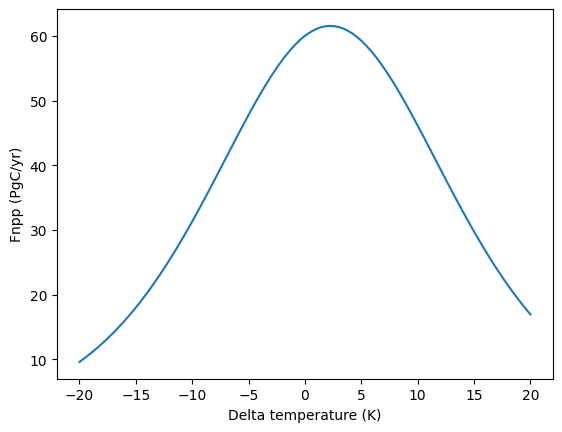

In [17]:
t=np.linspace(-20,20,100)
f=ccmod_default.fnpp_from_temp(t)
plt.plot(t,f)
plt.xlabel('Delta temperature (K)')
plt.ylabel('Fnpp (PgC/yr)')

Text(0, 0.5, '')

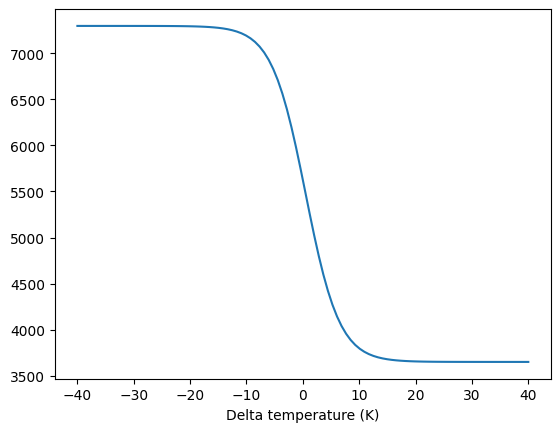

In [18]:
t=np.linspace(-40,40,100)
f=ccmod_default.mixed_layer_temp_feedback(t)*75
plt.plot(t,f)
plt.xlabel('Delta temperature (K)')
plt.ylabel('')

Text(0, 0.5, '')

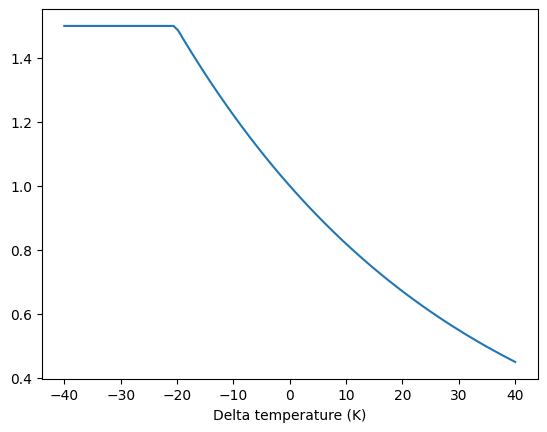

In [19]:
f=ccmod_default.solubility_temp_feedback(t)
plt.plot(t,f)
plt.xlabel('Delta temperature (K)')
plt.ylabel('')